**Author:** Luca Fabbian <luca.fabbian.1999@gmail.com>.

Written during the "Operation Research 2" course, under the supervision of Professor Matteo Fischetti PhD, University of Padova, academic year 2022-2023.


# Overview
In this document, we will explore the Travelling Salesman Problem (TSP) {cite:biggs1986graph}, a well-known optimization problem that is notoriously difficult to solve. Due to the problem's NP-hard nature, assuming the P-NP hypotesys is true, it's impossible that any algorithm will be able to produce an exact solution in a reasonable amount of time for every instance. As a result, it's meaningful to focus on the tradeoffs between different resolution strategies, which have been studied by many researched through the years {cite:laporte1992traveling}.

- First, we will introduce the problem, provide insights into our setup, and explain our methodology ([Chapter 1](#overview)).
- Next, we will explore some heuristic methods, such as Nearest Neighbor, Extra Mileage and 2 Opt ([Chapter 2](#heuristics)).
- We will then explore some metaheuristic methods, such as Tabu Search, VNS, Simulated Annealing and Genetic Algotithms ([Chapter 3](#metaheuristic)).
- Finally, we will leverage the IBM CPLEX commercial solver and use techniques such as integer linear programming, which will even allow us find exact solutions. We will also discuss how to integrate the CPLEX solver into some metaheuristic approaches ([Chapter 4](#cplex-based-methods)).
- In the end, we will draw some conclusions ([Chapter 5](#conclusions)).

Throughout the document, we will provide both mathematical considerations and actual code implementations in `C++`. To make it easy for readers to follow along, relevant code snippets will be embedded directly within this document, which is generated from a Jupyter Notebook using the special `ipycpp` extension.






## Problem formulation
The Travelling Salesman Problem (TSP) can be formulated as follows: 

"given a list of nodes and the distances between each pair of nodes, the goal is to find the shortest possible route that visits each node exactly once and returns to the origin node".

In this document, we will focus on the symmetric version of the problem, which assumes that the distance between any two nodes A and B is the same as the distance between B and A.

To simplify the scenario, we will consider the nodes as bidimensional points $(x, y)$ and use the Euclidean distance formula to calculate the distance between them. Specifically, the Euclidean distance between two nodes A and B with coordinates $(x_a, y_a)$ and $(x_b, y_b)$, respectively, is given by the formula:

$$distance = \sqrt{(x_a - x_b)^2 + (y_a - y_b)^2}$$

This formulation of the problem was originally applied to finding the minimum distance tour between cities. However, the problem can also be applied to other scenarios.
The TSP has many real-world applications, including logistics, transportation, and manufacturing. For example, a delivery person or a service technician may need to visit multiple locations in a certain order while minimizing travel time and distance. The TSP can also be used to optimize the placement of components on a circuit board or to minimize the time needed for a machine to perform a set of tasks.

The problem was first introduced in the mathematical literature in the 1930s by mathematician Karl Menger and it gained popularity in the 1950s and 1960s due to the work of George Dantzig, Ray Fulkerson, and Selmer Johnson.

Despite the problem's simple formulation, the TSP is known to be NP-hard, which means that finding an optimal solution for large instances of the problem is computationally intractable. This means that, since it's not always possible to reach an optimal solution, we are also interested in approximation algorithms and heuristics to find near-optimal solutions.

The TSP continues to be an active area of research in computer science, with ongoing development and refinement of new algorithms and techniques. As a result, researchers continue to make progress in finding improved solutions for the problem, and the TSP remains a challenging problem to study.



## Code environment

We chose `C++` as the programming language for this document, and it proved to be the wisest choice for several reasons. Firstly, `C++` is a highly efficient language, allowing us to develop a fast and optimized solution to the problem. This was essential for meeting the strict performance requirements. Secondly, `C++` plays nicely with external libraries and tools commonly used in optimization problems, such as the CPLEX solver by IBM. Additionally, `C++` is a widely used language and provides way more utilieties and quality of life improvements compared to plain `C`. Overall, choosing `C++` for this project allowed us to develop a reliable and high-performing solution within a reasonable timeframe, making it an excellent choice for our needs.


This document has been generated from a Jupyter Notebook. Jupyter Notebooks are web-based interactive documents that allow users to create and share code, visualizations, and text. They are used in data science, research, and education to experiment and communicate ideas. They support various programming languages and provide a user-friendly interface for running code and visualizing results.

If you're interested in the source code used to create this document, including the data  behind, it is available on Github at <https://github.com/lucafabbian/op2>. You can access all the underlying code and resources used to generate this document, which allows you to reproduce the results and even build upon them.

Jupyter Notebooks typically use Python as their primary language, but with the help of a Jupyter extension called `ipycpp`, we were able to code in C++ within the same Jupyter environment.

`ipycpp` is a Jupyter kernel for running C++ code in Python notebooks. It compiles the code on the fly and prints the result, with no overhead. The package is a pure Python script and requires a suitable C++ compiler installed on the system. It provides a simple and hackable solution for those who care about speed and low-level control. It was developed by Luca Fabbian specifically for this project.

To get started, install Jupyter on your system and add the `ipycpp` package with:
```bash
pip install ipycpp
```


Then, begin your first cell with some special comments. These are comments that provide instructions for building and running a C++ program using the `ipycpp` library. The comments specify the location of the source code file, the build command to compile the code into an executable, and the command to run the resulting program. If everything works right, the cell below should run and print the usual *"hello world!"*.

In [8]:
// $$ipycpp_file:   src/main.cpp
// $$ipycpp_build:  bash build.sh
// $$ipycpp_run:    bin/main
// $$ipycpp_clevermain: true
#define NODEBUG
#include "include.cpp"
const auto DEFAULT_TSPFILE_SMALL = "./data/pr439.tsp";
const auto DEFAULT_TSPFILE_LARGE = "./data/pr1002.tsp";

int main(){ printf("hello world!\n"); }

hello world!


We decided to wrote our code as a header only library, and pass parameters to it during compiling time using the -D (define) compiler flag, instead of passing them as command line arguments. In this way, the compiler is able to heavily optimize the resulted code.

Unfortunately, in many situations (in particular the ones in [Chapter 5](#cplex-based-methods)), we had to allocate too much memory for doing it in the stack, and so we resolved to use the much slower heap. To avoid memory leaks, we leverage on C++ smart pointers and RAII policy rather than plain malloc/calloc functions.

Finally, to further speed up our code, we stored solutions/tours as an array the sequence of nodes visited. Thanks to spacial locality, we could expect the memory access to be easier to cache, and thus much faster. In some cases, we would prefer to use a single linked list to store the nodes, which is stored in a single array where the element at index $i$ is the node that follows node $i$. Converting between the two data structures requires $O(n)$ time, where $n$ is the number of nodes. This is usually neglibile because it happens just once at the beginning of the algorithm, and once at the end.



## Algorithm evaluation and testbeds

TSP algorithms are typically compared using graphs, either a performance profile or a runtime distribution plot.

In this thesis we will focus on performance profiles.
A performance profile is a plot that compares the performance of different algorithms on a set of problem instances. The x-axis of the plot represents the ratio of the algorithm's runtime to the best runtime achieved by any algorithm on that problem instance. The y-axis represents the proportion of problem instances on which the algorithm achieved a certain ratio. The performance profile enables easy comparison of the algorithms' performance across different problem instances, as well as identifying the best algorithm overall and for specific instances.

For the TSP, our performance will be the score achieved by the algorithm on a given time limit.






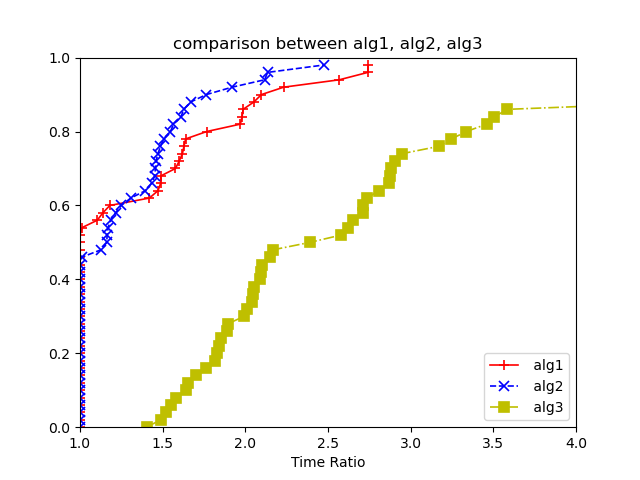

In [6]:
int main(){ 

  const int testbedLength = 50;
  int alg1results[] = { 140, 136, 187, 161, 101, 144, 130, 103, 179, 125, 183, 147, 134, 127, 173, 148, 126, 170, 122, 123, 106, 159, 166, 136, 171, 186, 165, 119, 161, 149, 131, 140, 126, 111, 159, 197, 164, 160, 168, 144, 109, 128, 144, 100, 140, 153, 131, 172, 101, 152 };
  int alg2results[] = { 166, 77 , 261, 235, 51 , 175, 151, 218, 234, 56 , 185, 74 , 156, 182, 152, 134, 269, 62 , 82 , 181, 164, 97 , 241, 85 , 105, 131, 193, 58 , 262, 92 , 51 , 94 , 142, 94 , 58 , 100, 162, 233, 263, 232, 182, 160, 217, 192, 247, 97 , 89 , 82 , 250, 226 }; 
  int alg3results[] = { 259, 250, 296, 250, 297, 254, 273, 299, 251, 292, 278, 256, 267, 265, 280, 269, 264, 293, 294, 294, 298, 263, 282, 298, 275, 284, 273, 293, 264, 265, 297, 270, 257, 277, 274, 258, 296, 291, 250, 273, 298, 275, 295, 287, 287, 263, 297, 260, 268, 287 };

  // plot points
  FILE *fptr;
  fptr = fopen("./plot/perfcsv.csv","w");
  if(fptr == NULL){
    printf("Error opening!");   
    exit(1);             
  }

  fprintf(fptr, "3, alg1, alg2, alg3\n");
  for (int i = 0; i < testbedLength; i++){
    fprintf(fptr, "test%d, %d, %d, %d\n", i, alg1results[i], alg2results[i], alg3results[i]);
  }
  fclose(fptr);

  system("python3 plot/perfprof.py -D , ./plot/perfcsv.csv ./plot/result.png -P 'comparison between alg1, alg2, alg3'\n");
  printf("$$$ipycppr_file$$$%s\n", "plot/result.png");

}

For testbeds, we will consider files provided by [TSPLIB](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/). TSPLIB is a library that provides a standardized collection of benchmark instances for the Traveling Salesman Problem. It includes a common format for researchers and practitioners to compare the performance of different TSP algorithms. TSPLIB files corresponds to real world instances, and thus they are guaranteed to be an accurate testbed. We also wrote the function `generateRandomTSPFile` function to extend this collection as needed with random instances.

If this was a real paper, we should have tested our algorithms against many instances and with long time limits, maybe taking the average score on multiple runs. Taking the average is highly recommended by literature, since many algorithms involved are believed to be chaotic (small changes in the input may cause drastic changes in the output).

In order to save time and computational power, however, we chose to focus on a smaller testbed of 10 elements spanning from 100 to 1000 points, and run each algorithm for 10mins each, when not stated otherwise. Check the `src/perf.cpp` file for more details.

# Heuristics
In this chapter, we will discuss some heuristics approaches to solve the TSP.

Heuristic approaches are problem-solving strategies or techniques that prioritize efficiency and speed over guaranteed accuracy. They involve using rules of thumb, educated guesses, or simplified decision-making processes to quickly find approximate solutions to complex problems. As said, for larger instances of the TSP it's impractical or too time-consuming to exhaustively search for the best possible solution: in those cases, heuristics can provide an effective alternative, even though they do not provide a proof of optimality.

Usually heuristic approaches are based on parameters which values cannot be chosen in an obiquitous way. In such cases, they can be tuned to achieve better results, we can repeat the heuristic for each value, or we can just choose a random value to speed up the computation.
Those params would be referred as hyperparameters.

We will first discuss two algorithms to construct solutions from scratch (Nearest Neighbour and Extra Mileage), and then a technique to improve existing solutions (2 Opt).

## Constructive Heuristics

### Nearest Neighbor
This is a greed approach where we start from a point A, we find the nearest point B of that point and add that to the tour. Then we move on B and find the nearest point C which is not in the tour already. We iteratively repeat this process until we add all the points to the tour.

Assuming "adding a point to the tour" is a constant time operation, we need to repeat it $n$ times, and each time we have to evaluate $(dimension - n)$ remaining nodes, thus the algorithm is $ O(n^2)$ time complexity. The starting point is a hyperparameter. Looping through each starting point, adds a layer of complexity, making the overall complexity $ O(n^3)$.

Seconds: 9
Param1 = 848,  cost = 307820


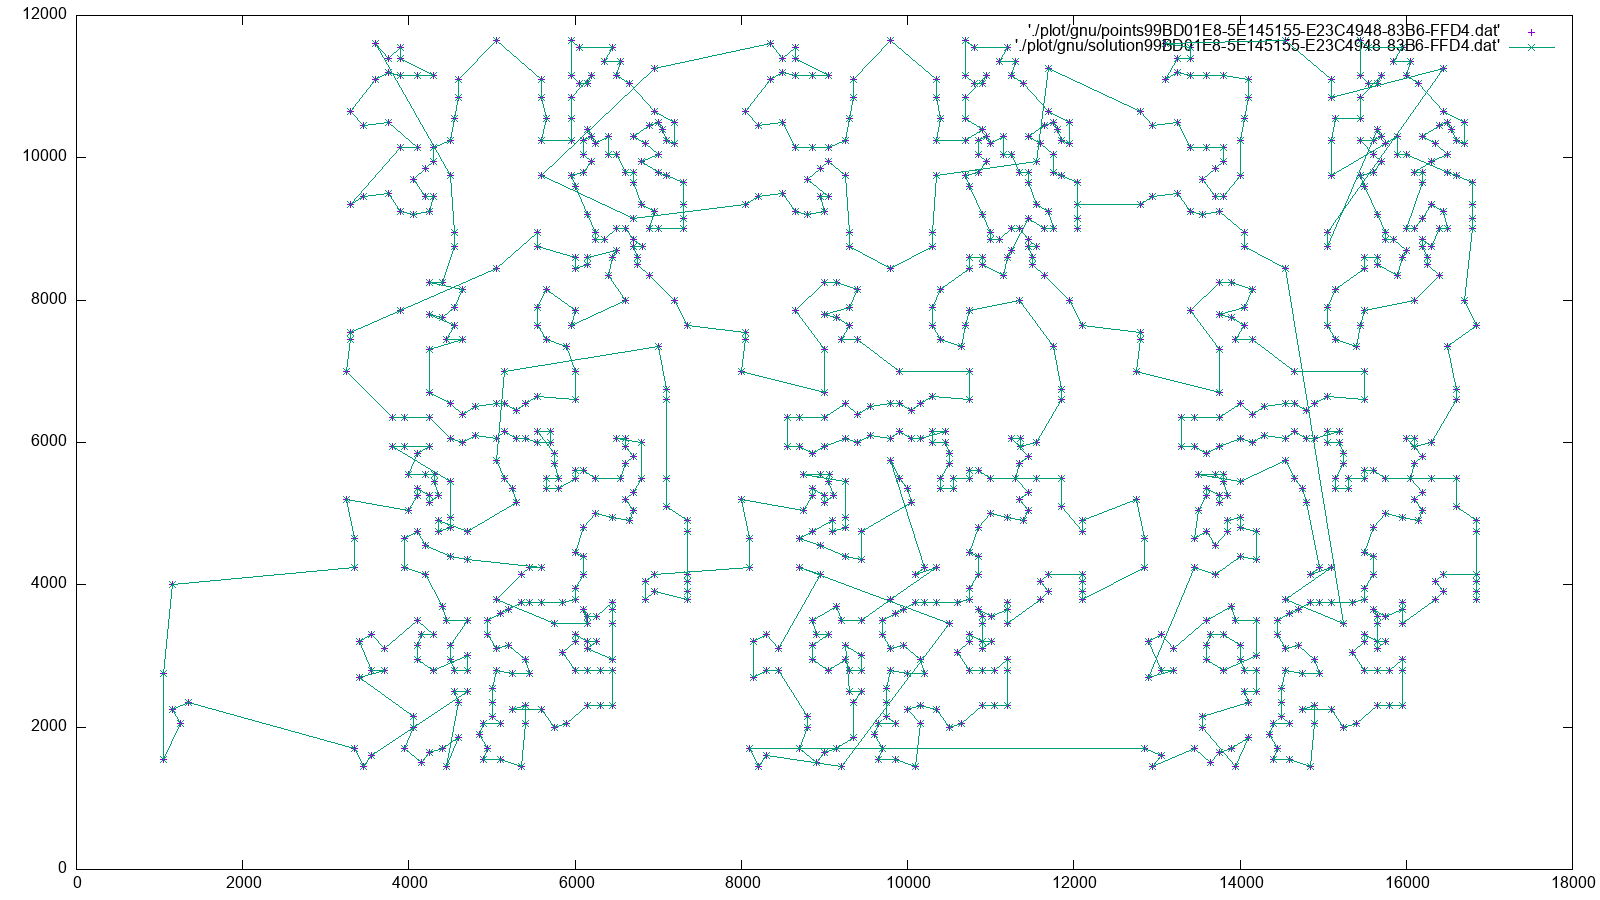

In [9]:
// Example of running the nearest neighbor algorithm for each starting point.
int main () {
  TSP tsp(DEFAULT_TSPFILE_LARGE);
  time_t timeLimit = time(NULL) + 60;
  printResult(solveSingleThread(nearest, tsp, timeLimit, {0, tsp.dim, 1}));
}

To speed up the computation, we may parallelize the code.

Seconds: 2
Param1 = 481,  cost = 306616


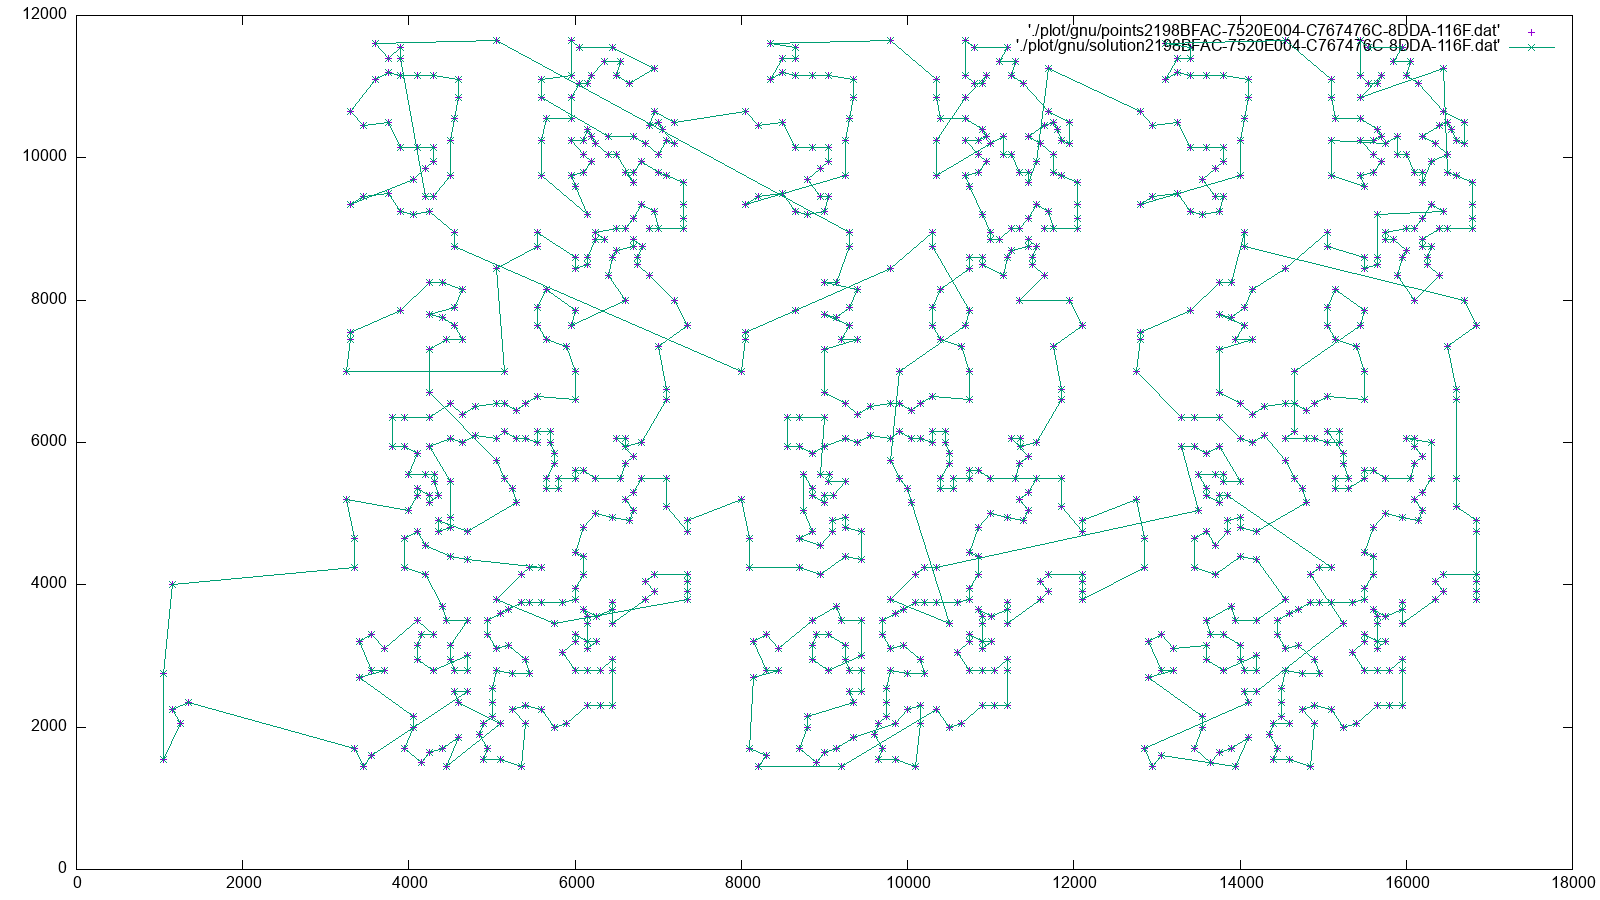

In [10]:
// Parallelized version of the previous method.
int main () {
  TSP tsp(DEFAULT_TSPFILE_LARGE);
  time_t timeLimit = time(NULL) + 10;
  printResult(solveMultiThread(nearest, tsp, timeLimit, {0, tsp.dim, 1}));
}

#### Extra Mileage
Another greed approach.

Given a subtour of $k$ points, we represent it as the sequence of nodes visited by the subtour. Then we take one of the remaining points and add it to the sequence, as if we were performing a list insertion at a certaing index. In order to find the best node to add and the best index, we iteratively scan all the possibilities and choose the one which produces the lowest total cost. In this way, we obtain a subtour of $k + 1$ points. We can then repeat this process until we get to a complete tour.

There are many ways to choose the initial subtour. Usually we start with one made by two points. The first one may be chosen as an hyperparameter, and the second may be chosen as an hyperparameter as well, but usually a great choice is to maximize the distance from the first point.


In contrast to the Nearest Neighbor algorithm, here we need to scan all possible indexes and all possible remaining points at each iteration, so it could be easily proven that the algorithm is $O(n^3)$ time complexity. This becomes $O(n^4)$ if we try over all possible values for the first starting point, and $O(n^5)$ if we iterate over for the second starting point as well.

Seconds: 8


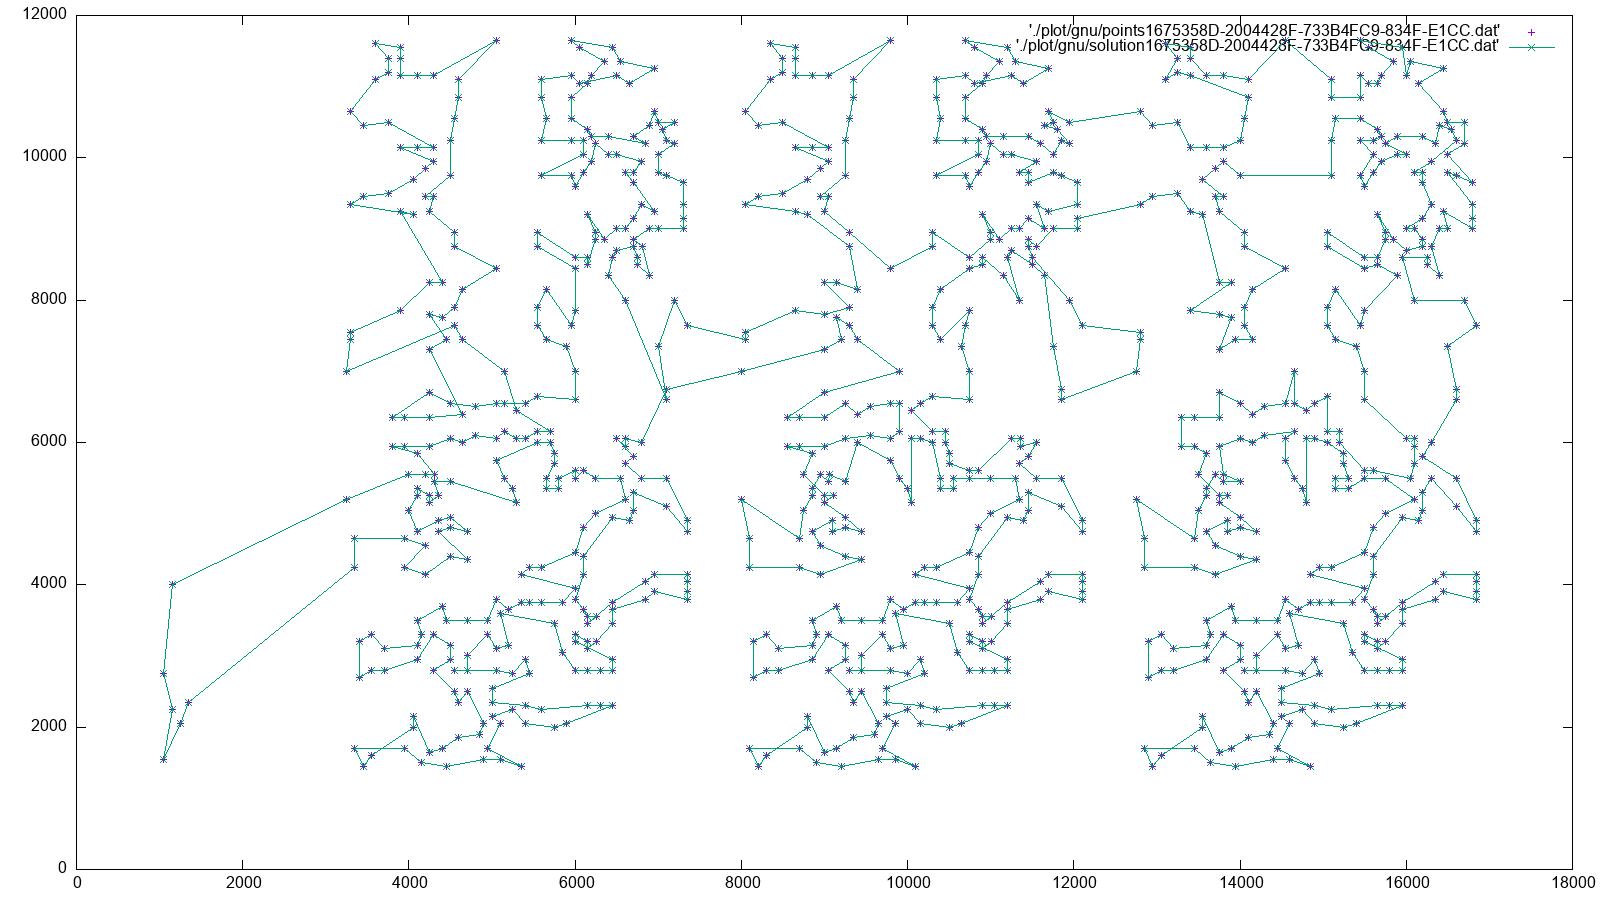

In [13]:

int main(){
  TSP tsp(DEFAULT_TSPFILE_LARGE);
  TSPSolution sol(&tsp);
  time_t startTime = time(NULL);
  extraMileage(&sol, startTime + 60, 0);
  printf("Seconds: %ld\n", (time(NULL) - startTime));
  sol.plot();
}

### 2 Opt

The N-Opt procedure is a procedure that, given a solution, iterate over all possible set of N edges of that solution and tries all possible ways to recombine them, in orde to find the best one. This operation is repeated until no improvements are found.

As you may realize, in a solution with n points, the number of sets with N edges is $O(n^N)$, and thus the procedure quickly becomes computationally intensive with N > 2, and thus we usually resolve to apply the 2 Opt one.



## Comparison

# Metaheuristic
Metaheuristics are a high-level, problem-independent algorithmic framework that provides a set of guidelines or strategies to develop optimization algorithms. They are not resolution methods per se, but rather a set of algorithms and techniques that can be used to improve already known heuristics. This is sometimes achieved by starting from a solution, and moving to a close one. A key concept of metaheuristics is, indeed, the one of solution neighborbood, which is defined as the set of solutions close to a given solution, using a distance metric. In the TSP, a notable example of solution neighborbood is K-opt neighborhood: given a solution, the K-opt neighborhood is the set of solutions that can be reached from the given solution by erasing K edges and recombine them in a feasible way.


As you may have noticed, the heuristics outlined in chapter 2 require little time, and lack a mechanism for refining the solution even when there's ample time to do so. Thanks to the metaheuristics described in this chapter, we will address this limitation.

As in chapter 2, the methods described here involve hyperparameters that can be chosen on reasonable assumptions, or fine-tuned to achieve the best performance.


## General metaheuristics

### GRASP
The heuristics seen in [Chapter 2](#heuristics) are deterministic. While a deterministic algorithm is easier to reproduce and is more predictable, adding some randomness has many advantages.

GRASP (Greedy Randomized Adaptive Search Procedure) is a metaheuristic technique that is used to improve greed-based heuristic algorithms adding randomness.

Usually, greedy algorithms always choose the most promising action. With GRASP, we introduce a (small) probability to choose a less promising action at each step. This is because we are in a scenario where the most promising action does not guaranteed the overall optimality, and thus other actions may lead to a better overall solution. Of course, choosing a nonsensical action has little probability to get a good outcome, as well as always choosing to ignore the most promising action. We have to find a reasonable balance to make this technique effective.

In this thesis, we will focus on a GRASP variant of the [Nearest Neighbor algorithm](#nearest-neighbor) described earlier. In the original Nearest Neighbor algorithm, we used a greedy policy and always added to the tour the closest possibile point. Here we introduce a small probability to choose the second closed point instead.

When run once, it's unlikely this variant will find a better solution than the original Nearest Neighbor. However, given enough iterations, it will hopefully find a better solution than the original Nearest Neighbor, since every iteration will produce a different solution due to the introduced randomness.




## Two phases metaheuristics

These techniques commence with an initial solution, striving to enhance it by examining its neighborhood, and iterate this process until the allotted time elapses.

They follow a pattern of alternating between an exploration phase, in which they explore an extended neighborhood around the current solution, and a refinement/intensification phase, during which they seek a new solution by selecting the best one within that neighborhood.

The assumption here is that is relatively simple to find the best local solution in a neighborhood using algorithms such as 2 Opt; hopefully, if we expand or shift the neighborhood enough, we will find a new local minimum, better then the previous one.


### Variant Neighbor Search (VNS)

In the TSP context, the Variant Neighbor Search (VNS) works as follow: we take a feasible solution, randomly delete N > 2 edges and recombine them, and then find a new solution by applying the 2 Opt algorithm described in Chapter 2. We then take the new solution, and iterate the process over and over.

N is a hyperparameter, and is usually a fixed number. For our implementation, we set it to 3.


### Tabu
Let's take the Variant Neighbor Search (VNS) described above, and run it with N = 2.

You may realize that in this way the 2 Opt procedure will never output a new solution. That's because if we delete just 2 edges, the 2 Opt algorithm will take us back to the initial state. To avoid this, we may declare as "tabu" the move which would take us back to the initial state. Instead of using the usual 2 Opt procedure, we will avoid to make moves declared as tabu. Eventually, we hope to change the solution enough to find a new, better one.

Declaring moves as "tabu" is not trivial. A simpler implementation, consider nodes to be tabus instead. We chose to mark 2 of the nodes involved.


You may realize that, by forbidding new nodes at each iteration, we reach soon a state where there are no nodes left. That's why we need a "TABU tenure", i.e. a policy to unmark TABU nodes after a while.

We experimented with three different policies:

- **step policy**, the tabu tenure starts from a minimum value, then after 100 iterations, the value is set to a maximum. After other 100 iterations, is set back to the minimum, and so on. 
- **linear policy**, the tenure starts from a minimum value, then at each iteration is increased gradually by 1, until reaching the maximum. At this point, it starts decreasing by 1 until it reaches the minimum again, and so on.
- **random policy**, every 100 iterations, the tenure is set to a random value between the maximum and the minimum.

We chose $ max = n * 0.1 $ and $ min = n * 0.02 $, where $ n$ is the number of nodes in the graph.

Notice that the policy is a stateless function, taking as parameters just the number of nodes in the graph, and the current iteration number.

### Simulated annealing
Simulated Annealing is a probabilistic optimization algorithm inspired by the annealing process in metallurgy, where a material is heated to remove defects and then gradually cooled to achieve a more stable crystalline structure.

The idea is to have a global parameter $T$ (temperature). We start with a solution, and suggest some changes to this solution. At a high temperature, the algorithm is more likely to accept changes which even worsen the solution, allowing for larger explorations. As the temperature decreases, the algorithm becomes more selective.

In the TSP context, to suggest a change we remove two edges and recombine them. This is similar to a 2 Opt move, but the algorithm can accept changes which even worsen the solution.

The probability of accepting a change is given by the Metropolis criterion
$$P(\text{accept}) = e^{-\frac{\Delta E}{T}} $$
where $\Delta E$ is the cost difference between the current solution and the proposed solution.

For decreasing the temperature, we choose an exponential policy: at each iteration, we choose:

$$T_{iter + 1} = 0.95 * T_{iter} $$




### Genetic

Genetic algorithms are a specific class of heuristic algorithms inspired by the process of natural selection and evolution {cite:holland1992adaptation}. They work with a population of potential solutions rather than a single solution. Each solution, often referred to as an "individual" or "chromosome," is represented as a string of genes. At each iteration, new solution are generated from the indivuals, and worst performing solutions are discarted. As the algorithm progresses, the population tends to evolve towards better solutions. Genetic algorithms are a versatile and powerful optimization technique, particularly suited for complex problems with large solution spaces where traditional optimization methods may struggle. The key pieces of genetic algorithms are:

**Initialization:** The algorithm starts by creating an initial population of individuals. These individuals are usually generated randomly or through some heuristic method.

**Fitness Function:** Genetic algorithms require a fitness function that quantifies the quality of each individual in the population. The fitness function evaluates how well an individual solves the problem at hand. It guides the selection process by assigning a fitness score to each individual.

**Selection:** Genetic algorithms use a selection mechanism to choose individuals from the current population to become parents for the next generation. Individuals with higher fitness scores have a higher probability of being selected, but individuals with lower fitness scores also have a chance to be chosen to maintain diversity.

**Crossover (Recombination):** Crossover is a genetic operator that combines genetic material from two parent individuals to create one or more offspring. Depending on the problem and the chosen crossover strategy, this can involve swapping or recombining genes between parents.

**Mutation:** Mutation is another genetic operator that introduces random changes into an individual's genetic code. It helps explore the solution space and introduces diversity. Mutation rates are typically low to prevent excessive disruption of good solutions.


In the context of the TSP, each individual in the population represents a possible tour or permutation of cities. We implemented a genetic algorithm with the following characteristics:

**Initialization:** We generated an initial population of $N$ elements using both Nearest Neighbor + 2 Opt, and random instances + 2 Opt.

**Fitness Function:** Since we are working with valid solutions only, we may use the solution cost as our fitness function (lower cost implies an higher fitness). If we were not, we would had to apply a penalty to invalid solutions, in order to prioritize the selection of valid ones.

**Selection:** In our implementation, we select the top $N$ individuals from the current population, based on the cost. In this way, we always start each iteration with the same number $N$ of indivuals. Before discarding the worst solutions, we randomly select $N * 0.1$ pairs of solution and switch their ranking, in this way we allow some less-promising solutions to survive. The best solution is shielded from this switches, in order to guarantee that the cost never increases.

**Crossover (Recombination):** In the TSP, one common approach is to use ordered crossover (OX) or partially mapped crossover (PMX) to exchange genetic material between parent solutions while preserving the order of nodes. We experimented with some, and then worked in the following way: we choose a random split point in the middle of the sequence (linerly chosen between 1/4 and 3/4). We then take the element of the first parent until the splitpoint, and then complete the sequence using the elements from the second parent. We then proceed to remove duplicates from the sequence. Finally, we reintroduce missing nodes using the [Extra Mileage](#extra-mileage) method seen earlier. Finally, we shift the sequence by choosing a random point as the starting one (this does not change the sequence itself, but it changes how it will behave as a parent later).

**Mutated individuals:** We just generate mutated individuals by randomly selecting some individuals. We then erase pairs of edges from those individuals and recombine them randomly. This is similar to a 2 Opt operation, except that it usually worsen the overall cost.

# CPLEX-based methods

In this chapter, we will leverage the power of a linear programming solver to get better results. Linear programming solvers are software able to solve system of linear inequalities, and find the best solution according to a given cost function. To be more precise, we are going to use a mixed integer linear solver, which means that we allow some variables to be constrained to be integers.

While there exists open source solvers, they are way slower than commercial ones. In particular, the CPLEX solver by IBM proven to be one of the fastest through the years. 

In order to solve the TSP problem with CPLEX, we need to represent it as a linear model.
The TSP may be represented as a mixed integer linear model throught the following formulation:

$$
\begin{alignat}{2}
\text{min} \quad & \sum_{\forall (i, j) \in E} c_{ij}x_{ij} \\
\text{Subject to} \quad & \sum_{ \forall (i,j) \in \delta(v)} x_{ij} = 2 && \quad \forall v \in V \\
& 0 ≤ x_{ij} ≤ 1 && \quad \forall (i, j) \in E  \\
& x_{ij} Integer && \quad \forall (i, j) \in E
\end{alignat}
$$

In this model, each edge is represented by a binary variable $x_{ij}$, which is 0 or 1 depending on whether the edge is in the solution. 

The model so far is polynomial in size, however it is not complete, since it allows for set of cycles ("subtours") instead of one larger cycle. To avoid this problem, we need to introduce an exponential number of constraint and check the cardinality for each subset of the nodes.

$$ \sum_{(i,j) \in \delta(S)} x_e \leq |S| - 1, \quad \forall S \subset V: |S| \geq 2 $$

These constraints are called "subtours elimination constraints", or SEC for short.

Since it would be infeasible to write so many constraints, we will discuss how to add just a subset of them. We will then talk about some tricks to fine-tune the CPLEX solver for the TSP, and finally we will discuss how to integrate the CPLEX solver with some metaheuristic techniques.

## Exact methods

### Bender's Loop

One approach to solve the TSP with CPLEX is to use the Bender's Loop algorithm.
In this algorithm, we ask CPLEX to solve the TSP without the subtour elimination constraints. We would then inspect the output. If there is just one cycle, it means that there are no subtours, and thus we are done.

Since there are no subtour elimination constraints, however, the output will likely contain more than one cycle. We proceed to find all isolated components (subtours), and for each we add the respective subtour elemination constraint to the initial model. We have now a new model, which can be given to CPLEX again and that couldn't lead anymore to the previous output.

We iterate this process until we find a solution with no subtours.

### Callbacks

The nice thing about the Bender's method described above, is that it considers the solver as a blackbox, and thus is able to work with any solver, even commercial and close source ones.

Recent implementations of CPLEX, however, provide a better way to interact with the solver. This is done using callbacks, which are functions passed as arguments to the solver that the solver would call when needed. In particular, CPLEX provides a `CPX_CALLBACKCONTEXT_CANDIDATE` callback which is invoked every time CPLEX has a candidate solution. We can use this callback to check if the candidate solution has no subtour, and add subtours elimination constraints when needed.

The procedure to find connected components and add the respective constraints is the same as the one used in Bender's, however, since this happens inside CPLEX, it does not requires instanciating a new model. This should resolve in lesser overheads and overall better performance.

## Improving CPLEX performance

In this section, we will discuss how to improve the performance of CPLEX when solving TSP problems.

CPLEX is a powerful tool, yet it is also a general one with no context about the TSP. We could use our insight on the problem to fine tune CPLEX in order to make it more efficient.



### Posting solutions
Having a feasible solution to the problem helps CPLEX to run optimizations and preprocessing. The closer the solution to the optimal, the more powerful optimizations will be run.

We could use the heuristic techniques seen in [Chapter 2](#heuristics) and [Chapter 3](#metaheuristic) to find a feasible solution to the problem. In particular, we could use a constructive heuristic to find a feasible solution as a starting before invoking CPLEX, and pass it using the `CPXaddmipstarts` method.

We can also run a refinement heuristic such as 2 Opt to improve the candidate solution obtained inside a callback, and notify CPLEX about that using the `CPXcallbackpostheursoln` method.

### User cuts


### Patching heuristic


## Matheuristics
As stated in the introduction, it is well known the TSP is a NP problem. Even employing the most powerful solver, at some point instances will be too large to be computed efficiently. However, if we consider just a subset of the po

# Conclusions
